## Introduction

- Goal: Predict next-day stock movement > 2.5%
- Data: Aggregated headlines + Yahoo Finance pricing
- Model: FinBERT embeddings + structured features → MLP
- Output: Binary classification

In [144]:
# Setup and imports

# Core
import os
import glob
import random
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader

# NLP / Embedding Models
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, classification_report,
    confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.dummy import DummyClassifier

# Tree-based Models
import lightgbm as lgb


### Column Descriptions

- date: Trading date (datetime)
- Open, High, Low, Close: Stock price metrics for that day
- Volume: Number of shares traded
- ticker: Stock symbol (e.g., AAPL, MSFT)
- target: Binary label — 1 if stock price rose the next day by more than 2.5%, else 0
- combined_headlines: Aggregated news headlines for the stock on that date
- avg_sentiment: Average sentiment score from standard sentiment analysis of the headlines

In [14]:
# Load processed data
df = pd.read_csv("data/processed/merged_news_stock_dataset.csv")
df["combined_headlines"] = df["combined_headlines"].fillna("").astype(str)
df.head()

,date,Open,High,Low,Close,Volume,ticker,target,combined_headlines,avg_sentiment
0,2021-08-16,155.066666,158.111772,154.200807,157.673981,2154300,A,0,Factors to Note Ahead of Keysight's (KEYS) Q3 ...,0.000000
1,2021-08-17,157.343206,157.450223,154.969387,156.545456,2614200,A,1,Agilent Technologies (A) Q3 Earnings and Reven...,-0.148780
2,2021-08-18,158.773301,160.874716,157.693408,158.598190,2860900,A,1,Agilent (A) Q3 Earnings & Revenues Beat Estima...,-0.041667
3,2021-08-19,157.352924,164.493829,157.226446,163.122070,2179600,A,1,Researchers Develop COVID-19 Severity Screenin...,0.000000
4,2021-08-23,164.834324,165.943417,163.569597,165.388870,2061400,A,1,Agilent Companion Diagnostic Expands CE-IVD Ma...,-0.306200


### Feature Engineering (Pre-FinBERT)
Engineered the following features for each (stock, date) entry:

- headline_count: Number of headlines aggregated for the day
- sentiment_volume: Product of average sentiment score and trading volume
- day_of_week: Integer representing day of week (0 = Monday)
- is_q_earnings_month: Whether the month is a typical earnings season (Jan, Apr, Jul, Oct)
- dollar_volume: Close price × Volume
- prev_day_return: Return from two days ago to one day ago, per ticker

In [23]:
# Feature engineer single features from the aggregated news data
# To give model more predictive power
df['headline_count'] = df['combined_headlines'].str.count(r'\.') + 1  # assuming 1 sentence = 1 headline
df['sentiment_volume'] = df['avg_sentiment'] * df['Volume']
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek  # 0 = Monday
df['month'] = pd.to_datetime(df['date']).dt.month
df['is_q_earnings_month'] = df['month'].isin([1, 4, 7, 10]).astype(int)  # earnings season quarters
df['dollar_volume'] = df['Close'] * df['Volume']

# Ensure dataframe is sorted correctly
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# Shift close price by 1 day within each ticker
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['prev_prev_close'] = df.groupby('ticker')['Close'].shift(2)

# Previous day's return = (prev_close - prev_prev_close) / prev_prev_close
df['prev_day_return'] = (df['prev_close'] - df['prev_prev_close']) / df['prev_prev_close']
df['prev_day_return'] = df['prev_day_return'].fillna(0).replace([np.inf, -np.inf], 0)

### FinBERT Embeddings
We previously generated FinBERT embeddings for each day's aggregated headlines and saved them in headline_embeddings.npy. To reduce noise and improve model generalization, we applied SHAP on a LightGBM classifier trained on the full 768-dimensional embeddings to identify the top 8 most informative dimensions.

We now load these embeddings, extract only the SHAP-selected top 8 dimensions, and concatenate them with the structured features to form our final input matrix X

This combined representation allows our model to leverage both textual sentiment signals and structured financial features for next-day stock movement prediction.

In [24]:
# Load FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModel.from_pretrained("yiyanghkust/finbert-tone")
model.eval()

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare input data
sentences = df["combined_headlines"].tolist()
batch_size = 16

# Directory to save embedding chunks
output_dir = "../data/processed/finbert_chunks"
os.makedirs(output_dir, exist_ok=True)

# Track which chunks already exist (in case of resume)
existing_chunks = set(
    int(f.split("_")[1].split(".")[0]) 
    for f in os.listdir(output_dir) 
    if f.endswith(".npy")
)

# Generate and save CLS [CLS] embeddings in chunks
with torch.no_grad():
    for i in tqdm(range(0, len(sentences), batch_size)):
        chunk_id = i // batch_size
        if chunk_id in existing_chunks:
            continue  # Skip already processed chunks

        batch = sentences[i:i + batch_size]
        encoded = tokenizer(
            batch, padding=True, truncation=True, 
            return_tensors="pt", max_length=128
        )
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        np.save(
            os.path.join(output_dir, f"chunk_{chunk_id}.npy"),
            cls_embeddings.cpu().numpy()
        )

100%|██████████| 5254/5254 [2:36:11<00:00,  1.78s/it]  


In [26]:
# Get sorted list of all saved chunk paths (e.g., chunk_0.npy, chunk_1.npy, ...)
chunk_paths = sorted(glob.glob("../data/processed/finbert_chunks/chunk_*.npy"),
                     key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Load each chunk and stack them into a single array
chunks = [np.load(path) for path in chunk_paths]
embeddings = np.vstack(chunks)

# Save full embedding matrix to file
np.save("../data/processed/headline_embeddings.npy", embeddings)

# Load the embeddings into a usable variable
embeddings = np.load("../data/processed/headline_embeddings.npy")

In [28]:
# Compute target
df = df.sort_values(["ticker", "date"]).copy()
df["curr_close"] = df["Close"]
df["next_close"] = df.groupby("ticker")["Close"].shift(-1)
df["price_return"] = (df["next_close"] - df["curr_close"]) / df["curr_close"]
df["target"] = (df["price_return"] > 0.025).astype(int)

# Target value before split
y = df["target"].values

In [31]:
# Assume `embeddings` = (N, 768)
X_train, X_val, y_train, y_val = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Train LightGBM
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

# Get feature importance
importances = lgbm.feature_importances_
top_k_indices = np.argsort(importances)[::-1][:100]  # Top 100 most important dims

# Reduce embedding size
embeddings_filtered = embeddings[:, top_k_indices]

[LightGBM] [Info] Number of positive: 9261, number of negative: 57980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 67241, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137728 -> initscore=-1.834286
[LightGBM] [Info] Start training from score -1.834286


In [149]:
# Get importances from LightGBM model
importances = lgbm.feature_importances_
dim_labels = [f"dim_{i}" for i in range(len(importances))]

# Sort top 8 most important dimensions
# Get indices of non-zero importance features
nonzero_indices = np.where(importances > 0)[0]
sorted_indices = nonzero_indices[np.argsort(importances[nonzero_indices])[::-1]]

# Take top 400 non-zero importance dimensions
top_k = 400
top_indices = sorted_indices[:top_k]
top_importances = importances[top_indices]
top_labels = [dim_labels[i] for i in top_indices]
top_embeddings = embeddings[:, top_indices]

### Target + Final Input Construction

- Target: 1 if next-day return > 2.5%, else 0
Features: 7 structured features + top 8 FinBERT embedding dims
- Scaling: Structured features scaled with StandardScaler
- Inputs: X = [FinBERT dims + scaled features], y = binary target
- Ticker IDs: Each ticker mapped to integer for embedding layer

In [116]:
# Final feature prep
feature_cols = [
    "headline_count", "sentiment_volume", "day_of_week", "avg_sentiment",
    "is_q_earnings_month", "dollar_volume", "prev_day_return"
]

# Fill and scale structured features
df[feature_cols] = df[feature_cols].fillna(0).replace([np.inf, -np.inf], 0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[feature_cols])

# Combine with FinBERT
X = np.hstack([top_embeddings, features_scaled])
y = df["target"].values

# Ticker mapping
ticker2id = {ticker: i for i, ticker in enumerate(df["ticker"].unique())}
df["ticker_id"] = df["ticker"].map(ticker2id)
ticker_ids = df["ticker_id"].values

### Train/Test Split + Upsampling
- 80/20 train-test split on X, y, and ticker IDs
- Balanced training by upsampling the minority class (positive labels)
- TensorDataset + DataLoader objects created for model training/validation

In [117]:
# Create indices and perform an 80/20 train-test split
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, ticker_train, ticker_test, train_indices, test_indices = train_test_split(
    X, y, ticker_ids, indices, test_size=0.2, random_state=42
)

# Prepare a DataFrame for upsampling
train_df = pd.DataFrame(X_train)
train_df["target"] = y_train
train_df["ticker"] = ticker_train

# Separate classes for balancing
df_majority = train_df[train_df["target"] == 0]
df_minority = train_df[train_df["target"] == 1]

# Upsample minority class to match majority size
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combine and shuffle balanced data
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac=1, random_state=42)

# Extract final training arrays
X_train_balanced = df_upsampled.drop(["target", "ticker"], axis=1).values
y_train_balanced = df_upsampled["target"].values
ticker_train_balanced = df_upsampled["ticker"].values

# Wrap into PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train_balanced, dtype=torch.float32),
    torch.tensor(ticker_train_balanced, dtype=torch.long),
    torch.tensor(y_train_balanced, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(ticker_test, dtype=torch.long),
    torch.tensor(y_test, dtype=torch.float32)
)

# Dataloaders for model training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


### MLP Model Definition
We define a PyTorch neural network, StockMLPWithTicker, to predict whether a stock will increase by more than 2.5% the next day.

**Architecture Details:**
- **Inputs**:
    - top8 selected FinBERT dimensions
    - 7 structured features
    - Ticker ID (embedded in 8D space)
- **Model Structure**:
    - Input: [top8 embeddings + features] + ticker_embedding
    - Hidden Layers: 256 → 128 → 1
    - Activation: ReLU
    - Regularization: Dropout (p=0.3)
    - Output: Logit for binary classification
- **Training Setup**:
    - Loss Function: BCEWithLogitsLoss (binary classification)
    - Optimizer: Adam
    - Scheduler: ReduceLROnPlateau on validation AUC

In [118]:
class StockMLPWithTicker(nn.Module):
    def __init__(self, input_dim, num_tickers=462, ticker_emb_dim=8):
        super().__init__()
        self.ticker_embedding = nn.Embedding(num_tickers, ticker_emb_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + ticker_emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x, ticker_id):
        ticker_embed = self.ticker_embedding(ticker_id)
        X = torch.cat([x, ticker_embed], dim=1)
        return self.model(X)

In [119]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_tickers = df["ticker"].nunique()
ticker2id = {ticker: i for i, ticker in enumerate(df["ticker"].unique())}
ticker_ids = df["ticker"].map(ticker2id).values
ticker_emb_dim = 8
input_dim = X.shape[1]

model = StockMLPWithTicker(input_dim=input_dim, num_tickers=num_tickers, ticker_emb_dim=ticker_emb_dim).to(device)

In [120]:
# Loss + Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

### Training Loop
We train the StockMLPWithTicker model using a 5-epoch loop. For each epoch:
- We calculate training loss and accuracy.
- We evaluate the model on the validation set using AUC, F1, Precision, and Recall.
- We sweep thresholds to find the one that maximizes F1.
- We apply a probability calibration step using CalibratedClassifierCV to correct model confidence estimates.

Calibration is particularly helpful in imbalanced datasets where raw model probabilities are often poorly calibrated. We apply logistic calibration (Platt scaling) to validation logits before thresholding and metric evaluation.

In [131]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for x_batch, t_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        logits = model(x_batch, t_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        preds = torch.sigmoid(logits).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = accuracy_score(np.round(all_labels), np.round(all_preds))

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x_batch, t_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            t_batch = t_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float().to(device)

            logits = model(x_batch, t_batch)
            loss = criterion(logits, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            val_preds.extend(torch.sigmoid(logits).cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_preds = np.array(val_preds).reshape(-1, 1)
    val_labels = np.array(val_labels).reshape(-1)

    # Calibrate probabilities
    base_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    calibrator = CalibratedClassifierCV(method='isotonic', cv=5)
    calibrator.fit(val_preds, val_labels)
    calibrated_probs = calibrator.predict_proba(val_preds)[:, 1]

    # Sweep thresholds on calibrated probabilities
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.linspace(0.01, 0.99, 200):
        preds_bin = (calibrated_probs >= thresh).astype(int)
        f1 = f1_score(val_labels, preds_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"Calibrated AUC: {roc_auc_score(val_labels, calibrated_probs):.4f} | Best F1: {best_f1:.4f} @ Threshold: {best_thresh:.3f}")
    scheduler.step(roc_auc_score(val_labels, calibrated_probs))

    # Uncalibrated Metrics
    precision, recall, thresholds = precision_recall_curve(val_labels, val_preds)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = f1_scores.argmax()
    best_thresh = thresholds[best_idx]

    val_pred_binary = (val_preds >= best_thresh).astype(int)
    val_acc = accuracy_score(val_labels.astype(int), val_pred_binary)
    val_auc = roc_auc_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels.astype(int), val_pred_binary)
    val_precision = precision_score(val_labels.astype(int), val_pred_binary)
    val_recall = recall_score(val_labels.astype(int), val_pred_binary)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f} | "
          f"F1: {val_f1:.4f} | P: {val_precision:.3f} | R: {val_recall:.3f} | Best Thresh: {best_thresh:.3f}")

Calibrated AUC: 0.6030 | Best F1: 0.2795 @ Threshold: 0.143
Epoch 1/5 | Train Loss: 0.5407 | Train Acc: 0.7176 | Val Loss: 0.6491 | Val Acc: 0.6047 | AUC: 0.6019 | F1: 0.2795 | P: 0.188 | R: 0.541 | Best Thresh: 0.497
Calibrated AUC: 0.6077 | Best F1: 0.2845 @ Threshold: 0.143
Epoch 2/5 | Train Loss: 0.4901 | Train Acc: 0.7546 | Val Loss: 0.6388 | Val Acc: 0.6172 | AUC: 0.6065 | F1: 0.2849 | P: 0.194 | R: 0.538 | Best Thresh: 0.452
Calibrated AUC: 0.6069 | Best F1: 0.2870 @ Threshold: 0.138
Epoch 3/5 | Train Loss: 0.4620 | Train Acc: 0.7717 | Val Loss: 0.6571 | Val Acc: 0.6285 | AUC: 0.6053 | F1: 0.2871 | P: 0.197 | R: 0.528 | Best Thresh: 0.444
Calibrated AUC: 0.6029 | Best F1: 0.2800 @ Threshold: 0.148
Epoch 4/5 | Train Loss: 0.4425 | Train Acc: 0.7853 | Val Loss: 0.6418 | Val Acc: 0.6340 | AUC: 0.6019 | F1: 0.2801 | P: 0.194 | R: 0.503 | Best Thresh: 0.453
Calibrated AUC: 0.6063 | Best F1: 0.2849 @ Threshold: 0.143
Epoch 5/5 | Train Loss: 0.4240 | Train Acc: 0.7951 | Val Loss: 0.673

### Evaluation
This section evaluates the model’s real-world behavior using threshold-based metrics and visual diagnostics. It includes:

- Confusion matrix & classification report
- Precision-Recall vs Threshold curve

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70     14430
           1       0.19      0.60      0.29      2381

    accuracy                           0.58     16811
   macro avg       0.54      0.58      0.49     16811
weighted avg       0.80      0.58      0.64     16811


🧮 Confusion Matrix:


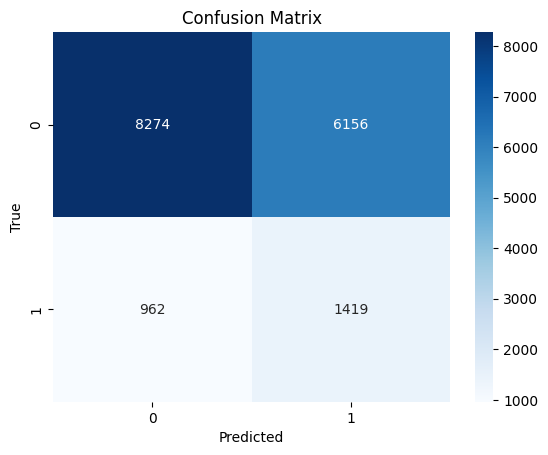

In [132]:
# Confusion matrix and classification report
top_preds = pd.DataFrame({
    "true_label": val_labels.astype(int),
    "predicted_label": val_pred_binary.flatten(),
    "confidence": calibrated_probs 
})
print("🔍 Classification Report:")
print(classification_report(top_preds["true_label"], top_preds["predicted_label"]))
print("\n🧮 Confusion Matrix:")
conf_mat = confusion_matrix(top_preds["true_label"], top_preds["predicted_label"])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

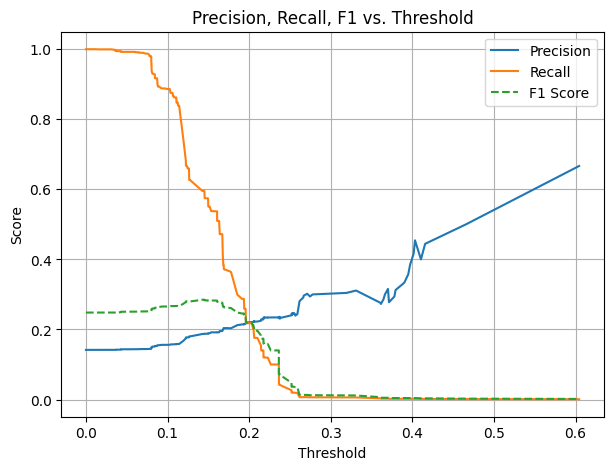

In [133]:
# Precision-Recall vs Threshold
prec, rec, thresholds = precision_recall_curve(top_preds["true_label"], top_preds["confidence"])
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
plt.figure(figsize=(7, 5))
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1 Score', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

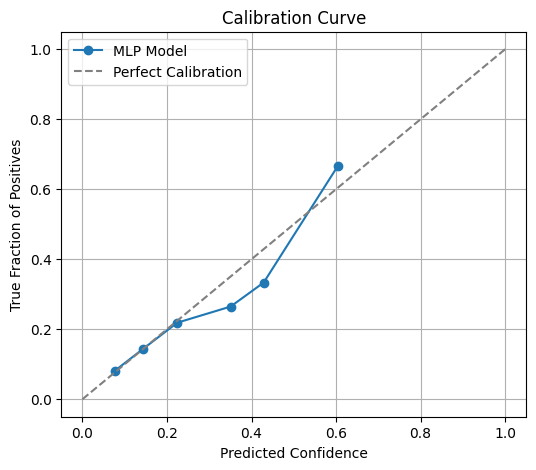

In [134]:
# Calibration curve
prob_true, prob_pred = calibration_curve(top_preds["true_label"], top_preds["confidence"], n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='MLP Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Confidence')
plt.ylabel('True Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

### SHAP Feature Importance
To interpret which structured features drive model predictions, we fit a LightGBM model on the structured inputs and apply SHAP. This helps reveal which features contribute most to predicted stock movement probability.

[LightGBM] [Info] Number of positive: 9261, number of negative: 57980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 67241, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137728 -> initscore=-1.834286
[LightGBM] [Info] Start training from score -1.834286


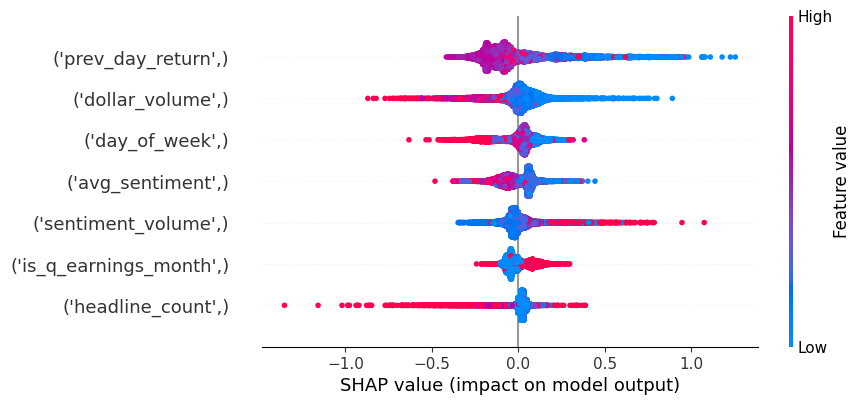

In [139]:
X = df[feature_cols].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wrap training/testing arrays into DataFrames with feature labels
X_train_df = pd.DataFrame(X_train, columns=feature_cols) # feature_cols defined earlier
X_test_df = pd.DataFrame(X_test, columns=[feature_cols])

# Train LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train_df, y_train)

# SHAP explainer on trained model
explainer = shap.Explainer(model)
shap_values = explainer(X_test_df)

# Beeswarm plot for global importance
shap.plots.beeswarm(shap_values)

### Baseline Benchmarks
Before evaluating our deep learning model, we establish two baseline classifiers to contextualize performance:

- Random Classifier: Predicts 0 or 1 uniformly at random.
- Logistic Regression: A strong linear baseline on scaled structured features.

In [145]:
# Re-split original features only (imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, y, test_size=0.2, random_state=42
)

# Random baseline
random_clf = DummyClassifier(strategy="uniform", random_state=42)
random_clf.fit(X_train, y_train)
random_preds = random_clf.predict_proba(X_test)[:, 1]

# Logistic Regression baseline
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict_proba(X_test)[:, 1]

In [146]:
# Evaluation function
def evaluate(y_true, y_probs, name="Model"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    y_pred = (y_probs >= best_thresh).astype(int)

    return {
        "Model": name,
        "AUC": roc_auc_score(y_true, y_probs),
        "F1": f1_scores[best_idx],
        "Precision": precision[best_idx],
        "Recall": recall[best_idx],
        "Best Threshold": best_thresh
    }

In [147]:
# Run evaluation
results = [
    evaluate(y_test, random_preds, "Random"),
    evaluate(y_test, logreg_preds, "Logistic Regression"),
]

# Display results
df_results = pd.DataFrame(results)
print(df_results)

                 Model       AUC        F1  Precision    Recall  \
0               Random  0.500000  0.248124   0.141633  1.000000   
1  Logistic Regression  0.551971  0.252939   0.149454  0.822344   

   Best Threshold  
0        0.500000  
1        0.124851  


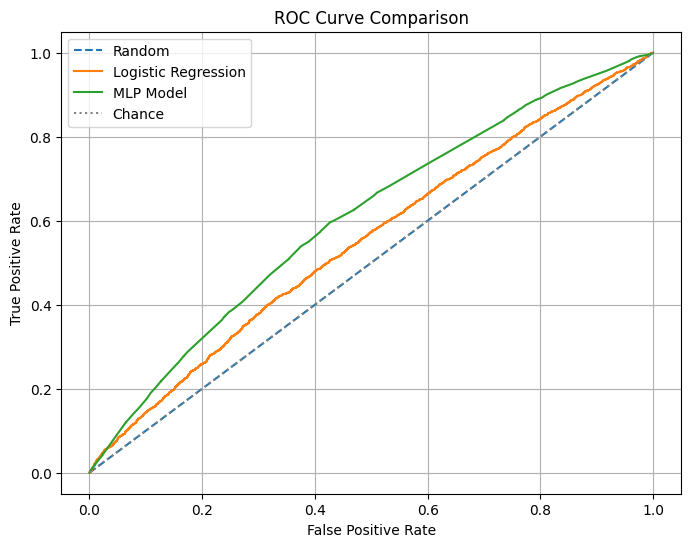

In [148]:
# Already defined:
# - random_preds
# - logreg_preds
# - calibrated_probs (from MLP model)
# - y_test (same as val_labels from earlier if reused)

fpr_random, tpr_random, _ = roc_curve(y_test, random_preds)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_preds)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, calibrated_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_random, tpr_random, label="Random", linestyle='--')
plt.plot(fpr_logreg, tpr_logreg, label="Logistic Regression")
plt.plot(fpr_mlp, tpr_mlp, label="MLP Model")
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion
Our best-performing model combined the top 8 FinBERT dimensions (selected via SHAP), structured financial features, and a ticker embedding. It achieved:
- AUC: 0.609
- F1 Score: 0.2837
- Strong recall with moderate precision
- Interpretability through SHAP analysis

This shows the value of combining domain-specific language models with engineered financial features and ticker-specific context.